# Find the top 'n' items in your org


Administrators often find themselves having to search and list items in their organization that match certain criteria. They might need this information for different administrative or auditing purposes. An example of such is to find items modified within the last 'n' days and sort them by their popularity or number of views. This notebook will work through such a use case of finding the top `100` public **[ArcGIS Dashboard](https://www.esri.com/en-us/arcgis/products/arcgis-dashboards/overview)** items sorted by **number of views** and output the results into a CSV file that can be used for reporting or ingested into any other system.

The configurations needed for this notebook are in the top few cells. While this exact use case may not be what you need, you can easily modify the configuration cells and adopt it to suit your reporting needs.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-arcgis-and-other-libraries" data-toc-modified-id="Import-arcgis-and-other-libraries-1">Import <code>arcgis</code> and other libraries</a></span></li><li><span><a href="#Set-up-search-parameters" data-toc-modified-id="Set-up-search-parameters-2">Set up search parameters</a></span></li><li><span><a href="#Search-for-ArcGIS-Dashboard-items" data-toc-modified-id="Search-for-ArcGIS-Dashboard-items-3">Search for ArcGIS Dashboard items</a></span></li><li><span><a href="#Compose-a-table-from-search-results" data-toc-modified-id="Compose-a-table-from-search-results-4">Compose a table from search results</a></span></li><li><span><a href="#Exploratory-analysis-on-the-top-'n'-items" data-toc-modified-id="Exploratory-analysis-on-the-top-'n'-items-5">Exploratory analysis on the top 'n' items</a></span><ul class="toc-item"><li><span><a href="#Make-a-word-cloud-out-of-the-item-titles" data-toc-modified-id="Make-a-word-cloud-out-of-the-item-titles-5.1">Make a word cloud out of the item titles</a></span></li></ul></li><li><span><a href="#Write-the-table-to-a-CSV-in-your-'files'-location" data-toc-modified-id="Write-the-table-to-a-CSV-in-your-'files'-location-6">Write the table to a CSV in your 'files' location</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-7">Conclusion</a></span></li></ul></div>

## Import `arcgis` and other libraries

In [1]:
from arcgis.gis import GIS
from datetime import datetime, timedelta, timezone
from dateutil import tz
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from IPython.display import display
import os
gis = GIS("home")

## Set up search parameters

In [2]:
# set up time zone for searching - 'PDT' in this example
la_tz = tz.gettz('America/Los_Angeles')

# set up a time filter - last 20 days in this example
end_time = datetime.now(tz=la_tz)
start_time = end_time - timedelta(days=20)

# sort order
search_sort_order = 'desc'

# search outside org?
search_outside_org = True

# number of items to search for
search_items_max = 100

# search item type
search_item_type = "Dashboard"

# output location
out_folder = '/arcgis/home/dashboard_counts'

ArcGIS stores the `created` and `modified` times for items as [Unix Epoch](https://en.wikipedia.org/wiki/Unix_time) millisecond timestamps in [UTC time zone](https://en.wikipedia.org/wiki/Coordinated_Universal_Time). The next cell will convert the start and end times to UTC timezone and then to Epoch. We multiply by 1000 to convert seconds to milliseconds.

In [3]:
end_time_epoch = end_time.astimezone(tz.UTC).timestamp()*1000
start_time_epoch = start_time.astimezone(tz.UTC).timestamp()*1000

# print settings
print(f'Time zone used: {end_time.tzname()}')
print(f'start time: {start_time} | as epoch: {start_time_epoch}')
print(f'end time: {end_time} | as epoch: {end_time_epoch}')

Time zone used: PDT
start time: 2020-09-25 22:22:18.008928-07:00 | as epoch: 1601097738008.928
end time: 2020-10-15 22:22:18.008928-07:00 | as epoch: 1602825738008.928


## Search for ArcGIS Dashboard items

Next, we will construct a search query using the parameters defined above and query the org. To learn about the different parameters you can query for, [see the search reference](http://bitly.com/1fJ8q31). You can combine this reference with the properties of Items [found here](https://developers.arcgis.com/rest/users-groups-and-items/item.htm) to construct complex queries.

Since our org does not have over 100 Dashboard items, for the purpose of illustration, we search across all of ArcGIS Online.

In [4]:
query_string = f'modified: [{start_time_epoch} TO {end_time_epoch}]'

# search 100 most popular ArcGIS Dashboard items across all of ArcGIS Online
search_result = gis.content.search(query=query_string, item_type=search_item_type, 
                                   sort_field='numViews', sort_order=search_sort_order,
                                   max_items=search_items_max, outside_org=search_outside_org)
len(search_result)

100

## Compose a table from search results
Our next step is to compose a Pandas DataFrame object from the search result. For this, we will compose a list of dictionary objects from the search results and choose important item properties such as item ID, title, URL, created time, view counts etc.

In [5]:
%%time
result_list = []

for current_item in search_result:
    result_dict = {}
    result_dict['item_id'] = current_item.id
    result_dict['num_views'] = current_item.numViews
    result_dict['title'] = current_item.title
    
    # process creation date
    date_modified = datetime.fromtimestamp(current_item.modified/1000, tz=tz.UTC)
    result_dict['date_modified'] = date_modified
    
    result_dict['url'] = current_item.homepage
    
    # append to list
    result_list.append(result_dict)

CPU times: user 437 µs, sys: 118 µs, total: 555 µs
Wall time: 559 µs


In [6]:
df = pd.DataFrame(data=result_list)

Print the table's top 5 and bottom 5 rows

In [7]:
df.head() # top 5

,item_id,num_views,title,date_modified,url
0,bda7594740fd40299423467b48e9ecf6,1950923268,Coronavirus COVID-19 (2019-nCoV),2020-10-08 20:56:35+00:00,https://www.arcgis.com/home/item.html?id=bda75...
1,85320e2ea5424dfaaa75ae62e5c06e61,961689924,Dashboard Coronavirus COVID-19 (Mobile),2020-10-08 20:56:24+00:00,https://www.arcgis.com/home/item.html?id=85320...
2,32cb2526e3044fe8b5392ac4c9a466bc,109083112,Covid19 Lietuva stats LINE portal MOB,2020-10-09 08:07:48+00:00,https://www.arcgis.com/home/item.html?id=32cb2...
3,e19b7292484a4c05bb2a74e1f00421ba,99927240,Covid-19 flat curve LT,2020-10-09 09:55:47+00:00,https://www.arcgis.com/home/item.html?id=e19b7...
4,8d0de33f260d444c852a615dc7837c86,84417372,Florida COVID-19 Confirmed Cases,2020-10-02 15:55:07+00:00,https://www.arcgis.com/home/item.html?id=8d0de...


In [8]:
df.tail() # bottom 5

,item_id,num_views,title,date_modified,url
95,31370c72d3844e6b962fcf8490718821,1458106,COVID Zip Code Dashboard,2020-10-07 16:42:49+00:00,https://www.arcgis.com/home/item.html?id=31370...
96,21bec056a9a6449abcca89a329868fd6,1454170,Douglas County NE COVID-19 Dashboard (retired ...,2020-09-29 14:19:30+00:00,https://www.arcgis.com/home/item.html?id=21bec...
97,ebb119cd215b4c57933b7fbe477e7c30,1421105,Tulsa County Public Health COVID-19 Cases,2020-10-15 20:49:48+00:00,https://www.arcgis.com/home/item.html?id=ebb11...
98,f1d9acad6d0947ecaae1aee987f13339,1405731,SSI COVID - 19 Dashboard Dansk,2020-10-15 12:20:59+00:00,https://www.arcgis.com/home/item.html?id=f1d9a...
99,dcf9e493894e49b1853737f1ca3f6c6f,1365022,SSI COVID - 19 Dashboard Dansk - Mobil,2020-10-15 13:04:53+00:00,https://www.arcgis.com/home/item.html?id=dcf9e...


## Exploratory analysis on the top 'n' items

Now that we can collected our data, let us explore it. First we create a histogram of the number of views to look at the distribution.

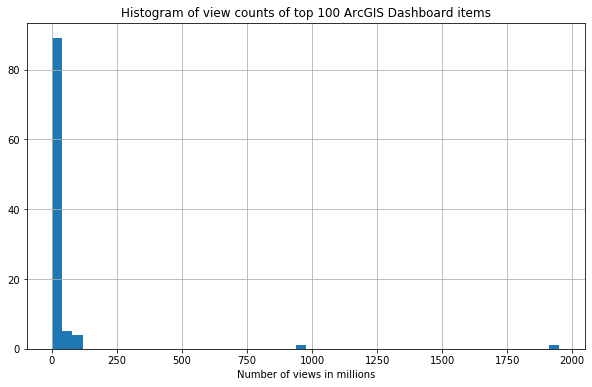

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
(df['num_views']/1000000).hist(bins=50)
ax.set_title(f'Histogram of view counts of top {search_items_max} ArcGIS {search_item_type} items')
ax.set_xlabel('Number of views in millions');

Most items in the top `100` list have less than one million views. We have a few outliers that have over a billion and one that is nearing a trillion views. We can find what those items are, simply by displaying the top few Item objects.

<Item title:"Coronavirus COVID-19 (2019-nCoV)" type:Dashboard owner:CSSE_GISandData>
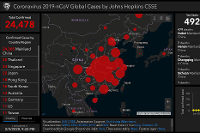

<Item title:"Dashboard Coronavirus COVID-19 (Mobile)" type:Dashboard owner:CSSE_GISandData>
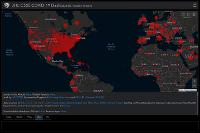

<Item title:"Covid19 Lietuva stats LINE portal MOB" type:Dashboard owner:15min.lt>
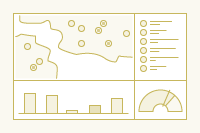

<Item title:"Covid-19 flat curve LT" type:Dashboard owner:15min.lt>
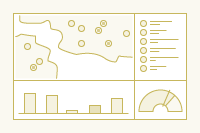

In [10]:
for current_item in search_result[:4]:
    display(current_item)

Next, let us visualize the last modified date as a histogram. The `date_modified` column is read as a `DateTime` object with minute and second level data. We will resample this column and aggregate on a per day basis. The cell below uses `Pandas` `resample()` method for the same.

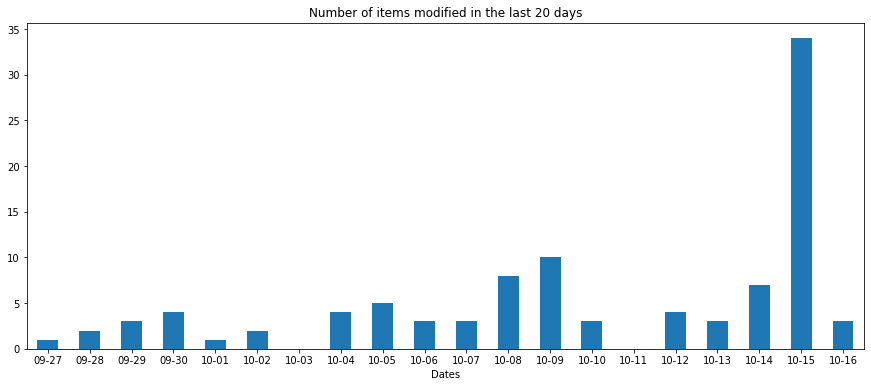

In [11]:
df2 = df.resample(rule='1D', on='date_modified')  # resample to daily intervals
last_modified_counts = df2['item_id'].count()

# simplify date formatting
last_modified_counts.index = last_modified_counts.index.strftime('%m-%d')

# plot last modified dates as a histogram
fig, ax = plt.subplots(figsize=(15,6))
last_modified_counts.plot(kind='bar', ax=ax)
ax.set(xlabel = 'Dates',
      title='Number of items modified in the last 20 days')
plt.xticks(rotation='horizontal');

### Make a word cloud out of the item titles

To make a word cloud, we use a library called `wordcloud`. As of this notebook, this library is not part of the default set of libraries available in the ArcGIS Notebook environment. However, you can easily install it as shown below:

In [12]:
!pip install wordcloud

     |████████████████████████████████| 365 kB 3.9 MB/s eta 0:00:01


Next we collect title strings from all the items and join them into a long paragraph.

In [13]:
%%time
title_series = df['title'].dropna()
title_list = list(title_series)
title_paragraph = '. '.join(title_list)
title_paragraph

CPU times: user 0 ns, sys: 4.08 ms, total: 4.08 ms
Wall time: 2.13 ms


'Coronavirus COVID-19 (2019-nCoV). Dashboard Coronavirus COVID-19 (Mobile). Covid19 Lietuva stats LINE portal MOB. Covid-19 flat curve LT. Florida COVID-19 Confirmed Cases. Covid19 Lietuva stats LINE portal. COVID-19 panel. COVID-19 ITALIA - Desktop. RKI COVID-19 Germany Mobil. RKI COVID-19 Germany LK. RKI COVID-19 Germany BL. JHU Centers for Civic Impact US COVID-19 Dashboard by County. COVID-19 ITALIA - Mobile. JHU Centers for Civic Impact US COVID-19 Dashboard by County   (Mobile). Synthèse Patients Covid19 en France - LCI Vertical. MD COVID-19 Data Dashboard. MD COVID-19 Data Dashboard (Mobile). COVID-19 In Texas (Dashboard). Cases and Trends. mobile - 都道府県別新型コロナウイルス感染者数マップ Coronavirus COVID-19 Japan Case (2019-nCoV) . 都道府県別新型コロナウイルス感染者数マップ Coronavirus COVID-19 Japan Case (2019-nCoV)【INFRAME】. State of Minnesota Gender Dashboard Percentage MDH. State of Minnesota Age Dashboard Percentage MDH. State of Minnesota Race Dashboard Percentage MDH. State of Minnesota Exposure Dashboard Pe

In [14]:
from wordcloud import WordCloud
wc = WordCloud(width=1000, height=600, background_color='white')

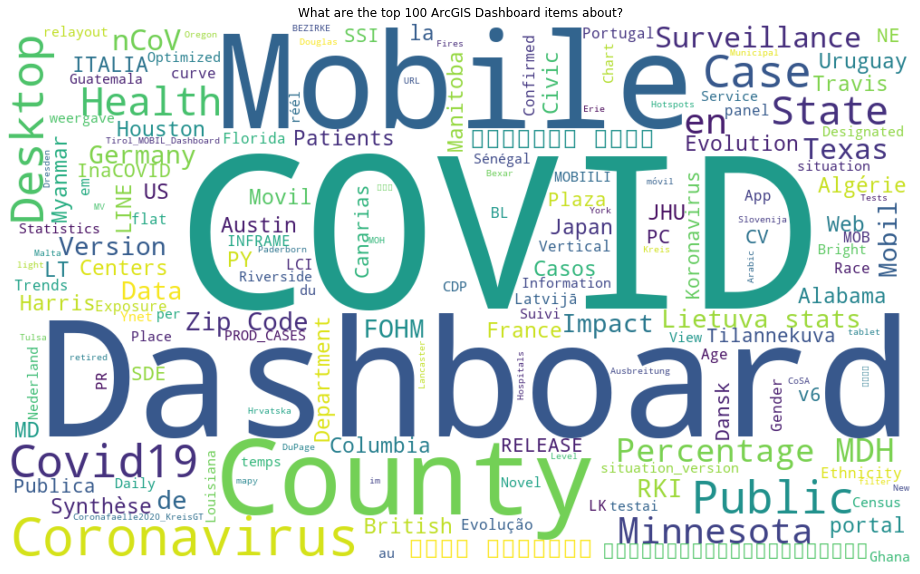

In [16]:
wc_img = wc.generate_from_text(title_paragraph)

plt.figure(figsize=(20,10))
plt.imshow(wc_img, interpolation="bilinear")
plt.axis('off')
plt.title('What are the top 100 ArcGIS Dashboard items about?');

Not surprisingly, most items are about the Novel Coronavirus. The word 'Dashboard' also appears pretty frequently enough.

## Write the table to a CSV in your 'files' location
We create a folder defined earlier in the configuration section of this notebook to store a `CSV` file containing the items table.

In [17]:
# create a folder for these files if it does not exist

if not os.path.exists(out_folder):
    os.makedirs(out_folder)
    print(f'Created output folder at: {out_folder}')
else:
    print(f'Using existing output folder at: {out_folder}')

Using existing output folder at: /arcgis/home/dashboard_counts


In [18]:
# append timestamp to filename to make it unique
output_filename = f"top_dash_items_{start_time.strftime('%m-%d-%y')}_to_{end_time.strftime('%m-%d-%y')}"

# write table to csv
df.to_csv(os.path.join(out_folder, output_filename))
print('Output csv created at : ' + os.path.join(out_folder, output_filename))

Output csv created at : /arcgis/home/dashboard_counts/top_dash_items_09-25-20_to_10-15-20


## Conclusion

This notebook demonstrated how to use the ArcGIS API for Python library to construct a search query and search for items in your org (or outside it). The notebook also demonstrated how to work with timezones, `datetime` objects and how to explore the meta data of the items collected. The notebook concludes by writing the table as a CSV on disk. If this kind of workflow needs to be repeated at set intervals, you can easily do so by [scheduling your notebook](https://enterprise.arcgis.com/en/notebook/latest/administer/windows/automate-notebook-execution.htm) to run at set intervals.